In [15]:
!pip install pyspark
!pip install geopy
!pip install pyarrow

## Initialise

In [16]:
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, to_timestamp, unix_timestamp, udf
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from geopy.distance import geodesic
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


spark = SparkSession.builder \
    .appName("BikeSharingAnalysis") \
    .config("spark.executor.heartbeatInterval", "300s") \
    .config("spark.network.timeout", "800s") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "12g") \
    .config("spark.driver.maxResultSize", "8g") \
    .config("spark.sql.shuffle.partitions", "100") \
    .getOrCreate()


# Load the data (update the path as needed)
data_path = r"C:\Users\PatrickSchenker\Desktop\orange_case_study\JC-202412-citibike-tripdata.csv\JC-202412-citibike-tripdata.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

## How many trips would be covered?

In [17]:
#How many trips would be covered?
# Filter trips that last more than 30 minutes
from pyspark.sql.functions import col, to_timestamp, unix_timestamp

# Convert start and end times to timestamp format
df = df.withColumn("started_at", to_timestamp(col("started_at")))
df = df.withColumn("ended_at", to_timestamp(col("ended_at")))
df = df.withColumn("trip_duration", (unix_timestamp(col("ended_at")) - unix_timestamp(col("started_at"))))
long_trips = df.filter(col("trip_duration") > 1800)  # 1800 seconds = 30 minutes
num_long_trips = long_trips.count()
print(f"Number of trips over 30 minutes: {num_long_trips}")

Number of trips over 30 minutes: 1015


## If your manager thinks we could charge 0.2 USD for each ride that takes longer than 30 minutes, how much revenue could we expect?

In [18]:
#If your manager thinks we could charge 0.2 USD for each ride that takes longer than 30 minutes, how much revenue could we expect?
revenue=num_long_trips*0.2
print(f"The expected revenue if we charged $0.20 USD for each trip lasting more than 30 minutes would be: {revenue}USD")

The expected revenue if we charged $0.20 USD for each trip lasting more than 30 minutes would be: 203.0USD


## Your manager wants to understand the travel distance in distance buckets (0-1,2-4,4-9,10+). Please make a diagram

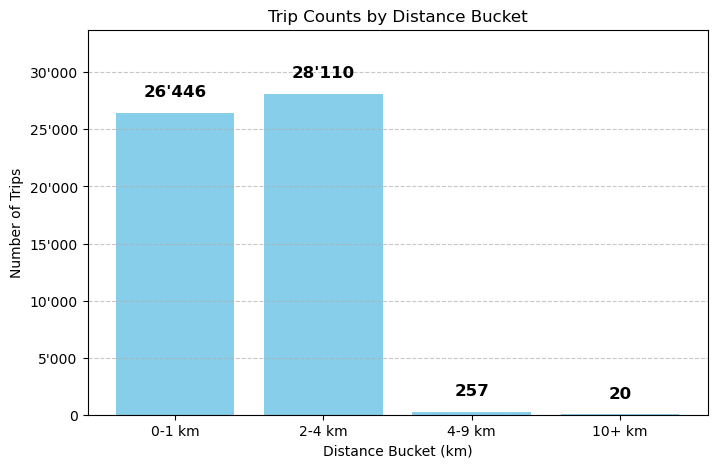

In [19]:
required_columns = {"start_lat", "start_lng", "end_lat", "end_lng"}

if required_columns.issubset(df.columns):
    from pyspark.sql.functions import radians, cos, sin, asin, sqrt, col, when, count
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mticker

    # Haversine formula for calculating distance between two latitude/longitude points
    def haversine_distance(lat1, lon1, lat2, lon2):
        return 6371 * 2 * asin(sqrt(
            sin((radians(lat2) - radians(lat1)) / 2) ** 2 +
            cos(radians(lat1)) * cos(radians(lat2)) *
            sin((radians(lon2) - radians(lon1)) / 2) ** 2
        ))

    # Compute distance column
    df = df.withColumn("distance_km", haversine_distance(
        col("start_lat"), col("start_lng"),
        col("end_lat"), col("end_lng")
    ))

    # Bucket distances into categories
    df = df.withColumn("distance_bucket",
                       when(col("distance_km") <= 1, "0-1 km")
                       .when(col("distance_km") <= 4, "2-4 km")
                       .when(col("distance_km") <= 9, "4-9 km")
                       .otherwise("10+ km"))

    # Aggregate counts for each bucket
    bucket_counts = df.groupBy("distance_bucket") \
                      .agg(count("distance_bucket").alias("count"))

    # Define the correct order for the distance buckets
    bucket_order = ["0-1 km", "2-4 km", "4-9 km", "10+ km"]

    try:
        # Convert to Pandas and enforce order
        bucket_counts_pd = bucket_counts.toPandas()
        bucket_counts_pd["distance_bucket"] = pd.Categorical(
            bucket_counts_pd["distance_bucket"], categories=bucket_order, ordered=True
        )
        bucket_counts_pd = bucket_counts_pd.sort_values("distance_bucket")

        buckets = bucket_counts_pd["distance_bucket"].tolist()
        counts = bucket_counts_pd["count"].tolist()
    
    except:
        # Fallback in case toPandas() fails
        bucket_data = {bucket: 0 for bucket in bucket_order}  # Initialize with zero counts
        for row in bucket_counts.toLocalIterator():
            bucket_data[row["distance_bucket"]] = row["count"]

        buckets = list(bucket_data.keys())
        counts = list(bucket_data.values())

    # Plot bar chart
    plt.figure(figsize=(8, 5))
    bars = plt.bar(buckets, counts, color="skyblue")
    
    def format_swiss_number(num):
        return f"{num:,}".replace(",", "'")  # Replace thousands separator with apostrophe

    # Add labels on top of each bar with spacing
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, 
                 bar.get_height() + (0.05 * max(counts)),  
                 format_swiss_number(count),  
                 ha='center', fontsize=12, fontweight='bold')

    # Format y-axis ticks using Swiss format
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: format_swiss_number(int(x))))
    
    # Set y-axis limit for better spacing
    plt.ylim(0, max(counts) * 1.2)  
    
    # Remove minor grid lines
    plt.grid(axis="y", linestyle="--", alpha=0.7, which="major")  
    plt.minorticks_off()  
    
    plt.title("Trip Counts by Distance Bucket")
    plt.xlabel("Distance Bucket (km)")
    plt.ylabel("Number of Trips")
    plt.xticks(rotation=0)
    
    plt.show()

else:
    print("Required columns not found.")
